# Tuned Gemini Flash 2.0 for citing sentence classification, balanced attempt

This notebook attempts to determine if a Gemini instance tuned on labeled examples is capable of producing a good results in detecting citing sentences.

The Gemini instance has been tuned on 10000 samples from a dataset of sentences extracted from scientific papers and labeled as citing or non-citing. Due to a previous failed experiment, this subset has been forcibly *balanced* to a perfect 50/50 split between cting and non-citing sentences.

## Instantiation

Using Google AI products requires the Google Cloud SDK to be installed on your system.

The following code initializes the Vertex project (I chose the project where I have the tuned model stored) and chooses a datacenter.

In [3]:
import vertexai

# Set up the VertexAI client
vertexai.init(
    project="citingsentececlassifier",
    location="europe-west9",
)

In [5]:
from google import genai
from google.genai import types

def generate(content: str):
  client = genai.Client(
      vertexai=True,
      project="438747908796",
      location="europe-west9",
  )


  model = "projects/438747908796/locations/europe-west9/endpoints/7379257940609335296"
  contents = [
      content
  ]
  generate_content_config = types.GenerateContentConfig(
    temperature = 0,
    top_p = 0.95,
    max_output_tokens = 256,
    response_modalities = ["TEXT"],
    safety_settings = [types.SafetySetting(
      category="HARM_CATEGORY_HATE_SPEECH",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_DANGEROUS_CONTENT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_HARASSMENT",
      threshold="OFF"
    )],
  )

  for chunk in client.models.generate_content_stream(
    model = model,
    contents = contents,
    config = generate_content_config,
    ):
    return chunk.text

## Invocation

We'll be using the model to classify a small set of sentences from scientific papers.

In [11]:
def generate_prediction(sentence: str) -> bool:
    messages = sentence

    return generate(messages) == "yes"

In [25]:
import pandas as pd

def filter_dataset(target_df: pd.DataFrame) -> pd.DataFrame:
  # drop na
  target_df = target_df.dropna()
  # remove any rows that have "<figure>" or "<formula>" on the `sentence` column
  target_df = target_df[~target_df['sentence'].str.contains('<figure>|<formula>')]

  # return shuffled version
  return target_df.sample(frac=1).reset_index(drop=True)


DATASET_PATH = "C:\\Users\\Adrian\\Documents\\datasets\\citing_test.parquet"

# Load the dataset into a pandas DataFrame
df = pd.read_parquet(DATASET_PATH)
df = filter_dataset(df)

# get first 500 rows
df = df.head(1000)

df.describe()

,sentence,citing
count,1000,1000
unique,1000,2
top,Shadows both increase the level of re- alism and provide information about spatial relationships of objects.,False
freq,1,932


In [26]:
# generate predictions asynchonously

import concurrent.futures

with concurrent.futures.ThreadPoolExecutor() as executor:
    predictions = list(executor.map(generate_prediction, df["sentence"]))

predictions

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fals

## Results

The model does way better than our previous Gemini experiment, but comparing it against our initial Scibert based model is difficult, as both have shortcomings:

* the fine tuned Gemini finds more citing sentences, but has way more false positives
* the Scibert based classifier doesn't that many false positives, but it finds less citing sentences overall

In [27]:
from sklearn.metrics import classification_report

report = classification_report(df["citing"], predictions)

print(report)

              precision    recall  f1-score   support

       False       0.99      0.83      0.90       932
        True       0.28      0.90      0.43        68

    accuracy                           0.84      1000
   macro avg       0.64      0.86      0.67      1000
weighted avg       0.94      0.84      0.87      1000



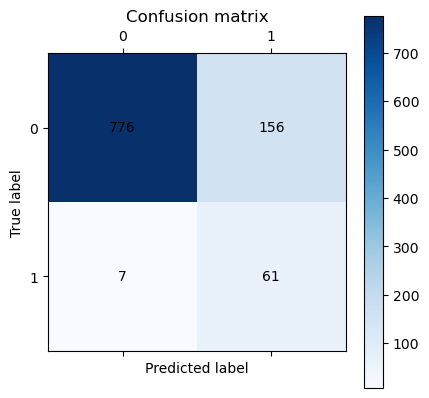

In [28]:
# confusion matrix image

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df["citing"], predictions)

# Plot the confusion matrix with numbers on squares
plt.matshow(cm, cmap = plt.cm.Blues)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.title("Confusion matrix")

plt.colorbar()

plt.ylabel("True label")

plt.xlabel("Predicted label")

plt.show()


In [29]:
# print wrong predictions
df[predictions != df["citing"]]

,sentence,citing
10,It proves that word embedding is a useful feature and is an effective way to make use of big unlabeled data.,False
16,Sustaining Moore’s Law in Embedded Computing through Probabilistic and Approximate Design: Retrospects and Prospects Krishna V.,False
18,It is easy to see that where the equalities hold in the memoryless AWGN channel.,False
42,"For comparison, we also run LIMMA, a standard method for differential expression analysis which tests for marginal mean-differences on a gene-by-gene basis .",False
44,] can provide means to reason about the descriptions with respect to given error traces.,False
...,...,...
956,Scott argues that these territories help group members organize their collaborative activities.,False
967,"(Nothing is logically more embarrassing than talking in tautologies.) Therefore, validities deserve arbitrarymessages as proof.",False
976,"Heath et al (2009) explore an intelligent gavel, linking internet bidders more dynamically into the action at live auctions.",False
984,Both these concepts were already present in MT.,False
